In [6]:
#generate scatter plot for Pattern Correlation against Maximum temperature (ERA5 Reanalysis)
#select heatwaves days from reanalysis data and highlight using geopotential and wind streamline plots
#PNW region


#specify dates from reanalysis and markers
date_string_list = ['2021-06-28', '2006-07-21', '1998-07-26', '2009-07-31']
color_list = ['r','g','c','m']
marker_list = ['s','^','*','D']


In [7]:
## Prashant Mahendran June 2022

# In[]: Specify the path out for all figures that will be saved i.e. the path to your directory on linux or the directory you wish to 
# save the figures
pathout ="/nfs/see-fs-01_teaching/ee21pnm/Project/output"

#Lat long boundaries
#Specify min and max values of latitude and longitude 
lat_min = 30
lat_max =70
lon_min = -145
lon_max = -70

#step between each gridline
step = 5
#gridlines
xlist = [*range(lon_min,lon_max+step,step)]
ylist = [*range(lat_min,lat_max+step,step)]

#pressure levels, maybe loop
pressure_level = 500


#Cities to Plot
def plot_cities(ax):
    lats = [45.523064, 47.6062, 49.2827]
    lons = [-122.676483, -122.3321, -123.1207]
    cities = ['Portland', 'Seattle', 'Vancouver']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'wo', zorder=5, MarkerSize=1, transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat, city, fontsize='medium',color='white',fontweight='bold',
                transform=ccrs.PlateCarree())
                
def plot_siberian_cities(ax):
    lats = [67.550]
    lons = [133.383]
    cities = ['Verkhoyansk']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'ro', zorder=5, MarkerSize=1, transform=ccrs.PlateCarree())
        ax.text(lon, lat + 3, city, fontsize='medium',rotation=30,fontweight='bold',
                transform=ccrs.PlateCarree())
##IMPORT PACKAGES

import cartopy.feature as cfeature ## for lakes/borders et
countries_50m = cfeature.NaturalEarthFeature('cultural','admin_0_countries','50m',edgecolor='k',facecolor='none')
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import matplotlib.ticker as mticker
import matplotlib.colors as clrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing
import datetime as dt
from matplotlib import gridspec
from matplotlib import rcParams

from scipy.stats import norm
import pandas as pd

crs = ccrs.PlateCarree()

##define constants
p0 = 1000   #base pressure level
rcp = 0.286 #gas constant divided by specific heat capacity
R_gas= 8.31 #ideal gas constant
G = 9.81 #gravity

#make function to convert all floats to integers in a matrix
def f1(x):
    return np.int(x)
f2 = np.vectorize(f1)

#make boundary for ALbers Equal Area Projection

import matplotlib.path as mpath

def make_boundary_path_sector_map(lons,lats):
    """
    Created on Thurs Feb 11 14:34 2021

    @author: Christine McKenna

    ===========================================================
    Purpose: Function to make a path around boundary to create
             a sector map
    ===========================================================
    """
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],\
                              lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],\
                              lats[0,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,0],\
                              lats[:,0]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

# Change to be the boundary you want
lats_bound = np.linspace(30,70,41) 
lons_bound = np.linspace(-145,-70,76)
[llo_bnd,lla_bnd] = np.meshgrid(lons_bound,lats_bound)
boundary_path = make_boundary_path_sector_map(llo_bnd,lla_bnd)

#make function for legend for streamplot

def speedToLW(wspeed, maxspeed):
    ''' 
    Function to convert windspeed into a sensible linewidth
    This will need to change depending on your data
    '''
    return 2*wspeed / maxspeed

def LWToSpeed(lw,maxspeed):
    ''' The inverse of speedToLW, to get the speed back from the linewidth '''
    return (lw/2) * maxspeed 

def makeStreamLegend(strm, lx, convertFunc,maxspeed, nlines=5, color='k', fmt='{:g}'):

    ''' Make a legend for a streamplot on a separate axes instance '''

    # Get the linewidths from the streamplot LineCollection
    lws = np.array(strm.lines.get_linewidths())

    # Turn off axes lines and ticks, and set axis limits
    lx.axis('off')
    lx.set_xlim(0, 1)
    lx.set_ylim(0, 1)

    # Loop over the desired number of lines in the legend
    for i, y in enumerate(np.linspace(0.1, 0.9, nlines)):

        # This linewidth
        lw = lws.min()+float(i) * lws.ptp()/float(nlines-1)

        # Plot a line in the legend, of the correct length
        lx.axhline(y, 0.1, 0.4, c=color, lw=lw)

        # Add a text label, after converting the lw back to a speed
        lx.text(0.5, y, fmt.format(convertFunc(lw,maxspeed)), va='center')
        

def suffix(d):
    return 'th' if 11<=d<=13 else {1:'st',2:'nd',3:'rd'}.get(d%10, 'th')

def custom_strftime(format, t):
    return t.strftime(format).replace('{S}', str(t.day) + suffix(t.day))



In [8]:
#scatter plot

#Read in spreadsheets
PNW_Corr = pd.read_excel('Spreadsheets/PNW_Corr_June2021_lowRES.xlsx', index_col=0)  
#PNW_Corr 

SIB_Corr = pd.read_excel('Spreadsheets/Siberia_Corr_June2020_lowRES.xlsx', index_col=0)  
#SIB_Corr

#SIB_Corr1988 = pd.read_excel('Spreadsheets/Siberia_Corr_25071988_v2.xlsx', index_col=0)  
#SIB_Corr1988

PNW_MaxTemp = pd.read_excel('Spreadsheets/Maxtemp_PNW.xlsx', index_col=0)  
#PNW_MaxTemp 

SIB_MaxTemp = pd.read_excel('Spreadsheets/Maxtemp_Siberia.xlsx', index_col=0)  
#SIB_MaxTemp
#join p_corr to Maxtemp dataframe
PNW_all = PNW_Corr.join(PNW_MaxTemp.set_index('dates'), on='dates')
SIB_all = SIB_Corr.join(SIB_MaxTemp.set_index('dates'), on='dates')
#add month column
PNW_all['Month'] = pd.to_datetime(PNW_all['dates']).dt.to_period('M')
SIB_all['Month'] = pd.to_datetime(SIB_all['dates']).dt.to_period('M')

#find max for each month
SIB_Max = PNW_all.loc[PNW_all.groupby(["Month"])["Max_Temp"].idxmax()]
PNW_Max = SIB_all.loc[SIB_all.groupby(["Month"])["Max_Temp"].idxmax()]

/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


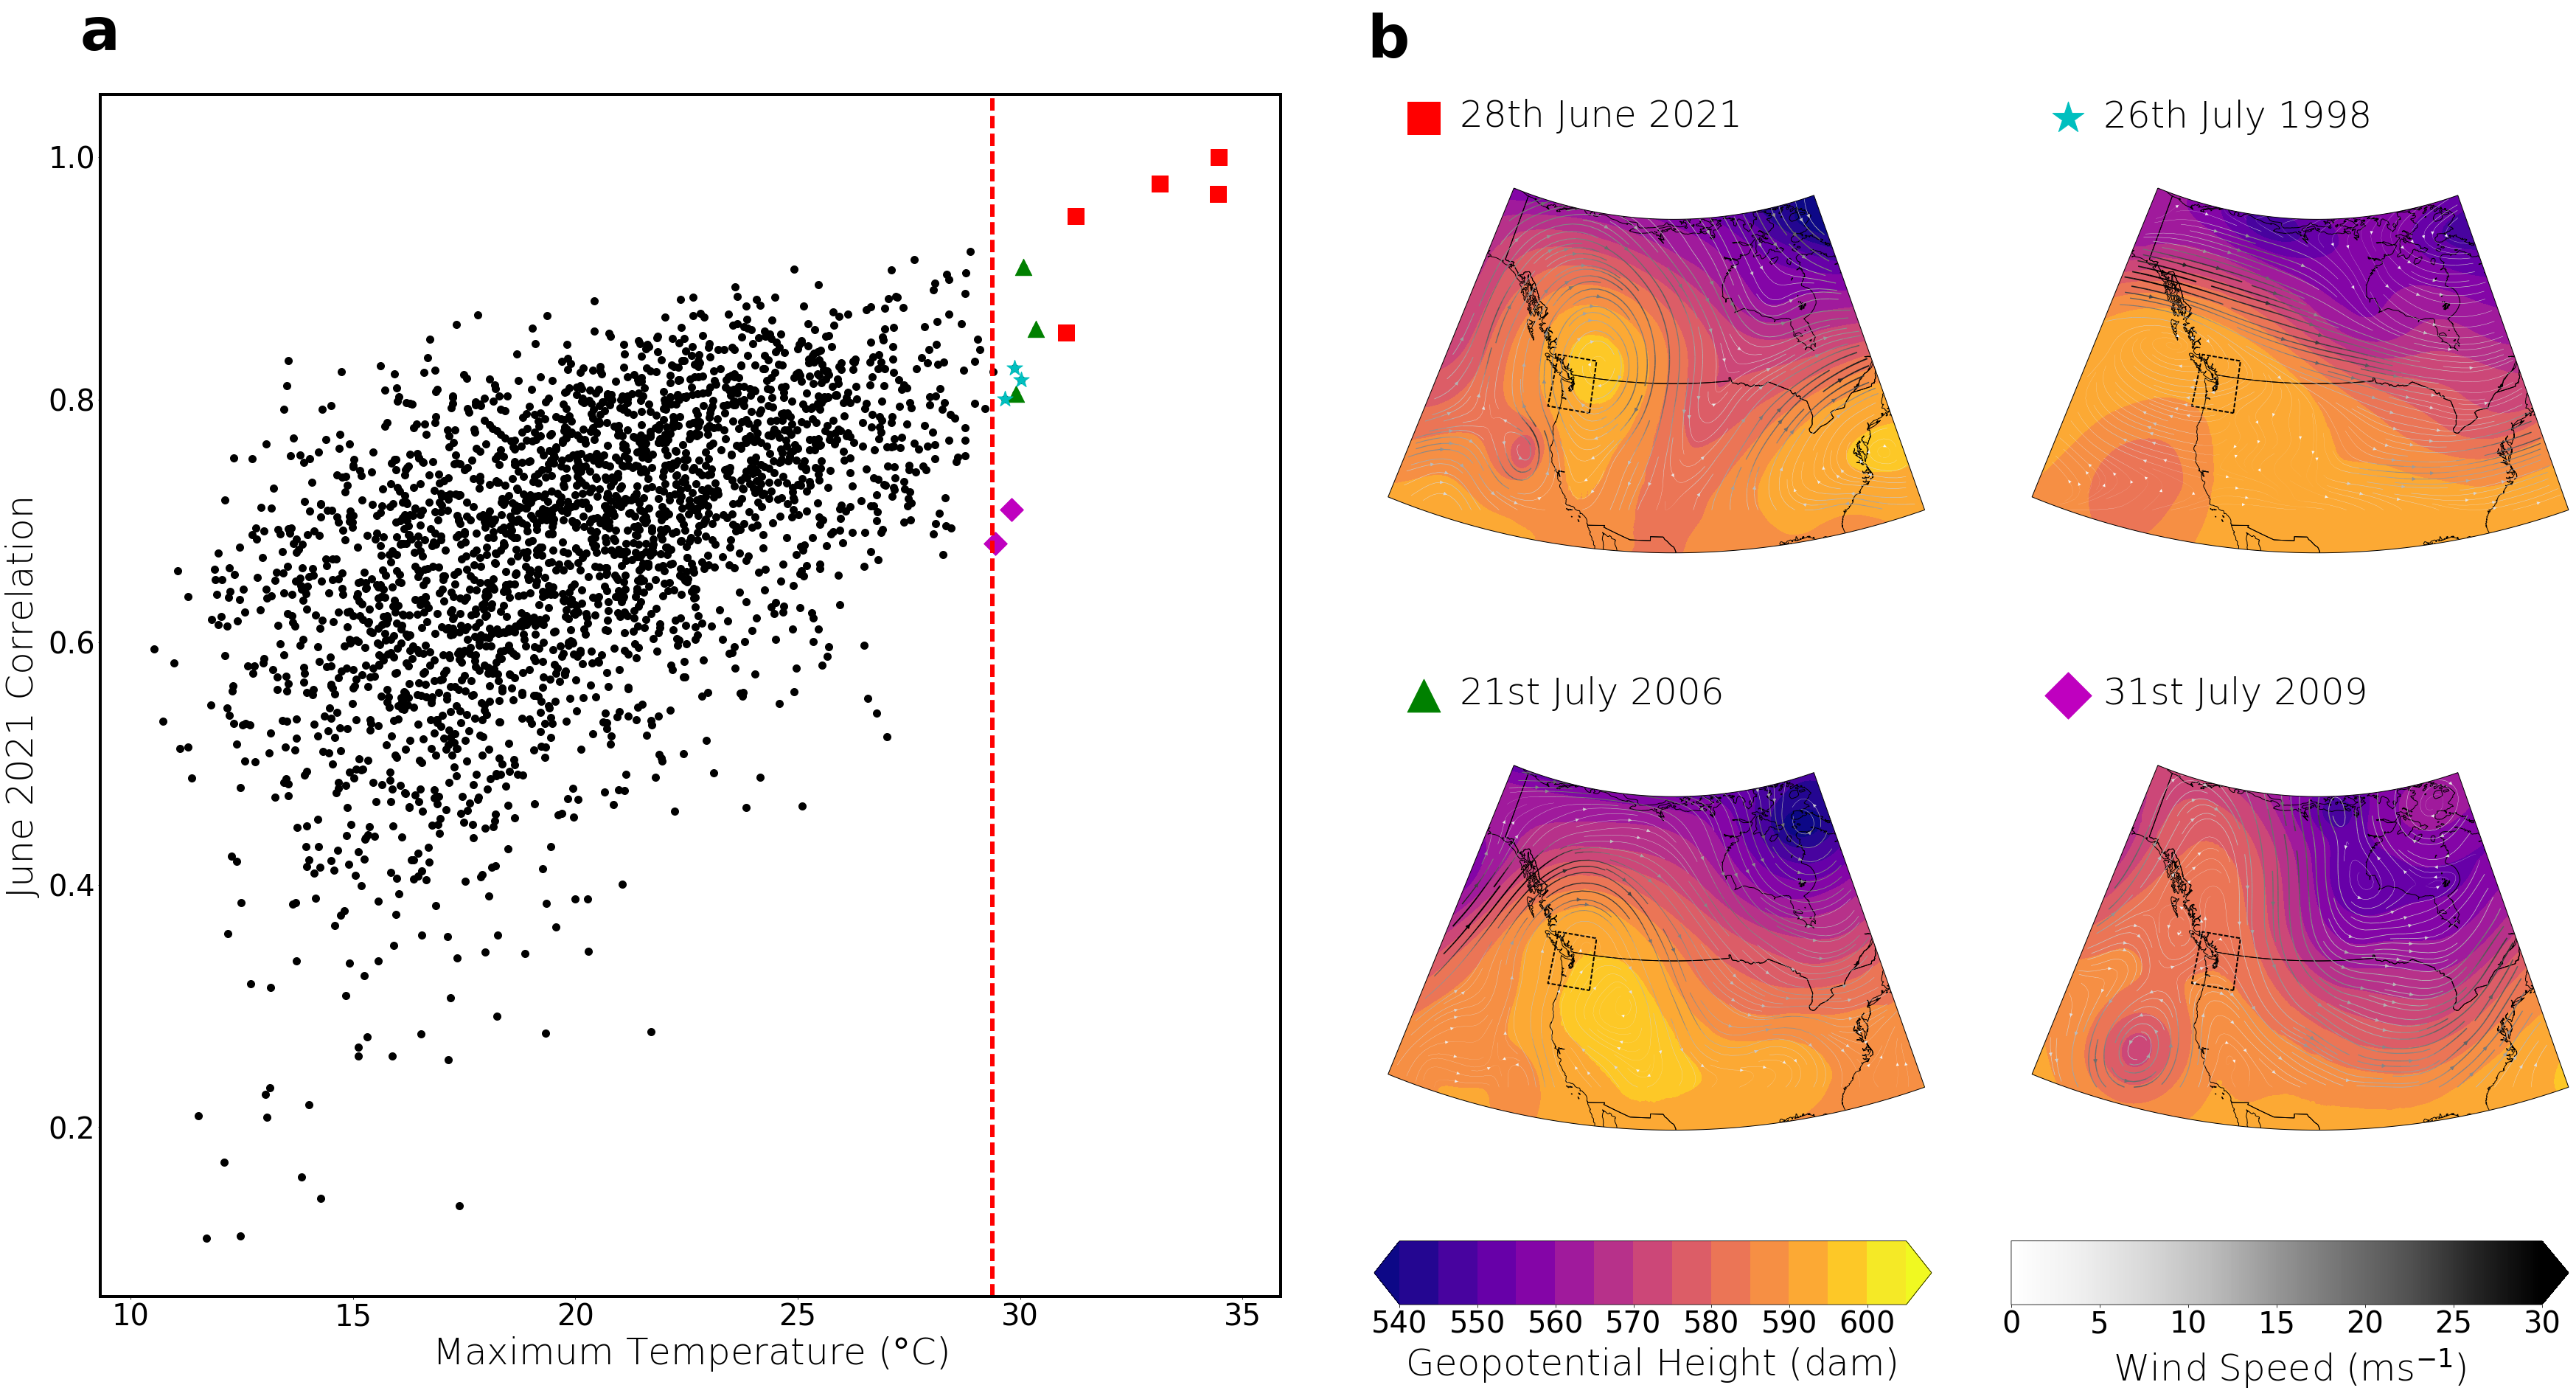

Complete!


In [11]:
#scatter plot
#plot scatter PNW
fig1 = plt.figure(figsize=(60,30))
fig1.patch.set_facecolor('w')

#grid
gs = gridspec.GridSpec(21,4)


ax = fig1.add_subplot(gs[:,0:2])
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)
#axes labels
ax.set_xlabel('Maximum Temperature ($\degree$C)', fontsize=50, fontweight='light')
ax.set_ylabel('June 2021 Correlation', fontsize=50, fontweight='light', labelpad=10)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

#scatter plot
ax.scatter(PNW_all['Max_Temp'],PNW_all['p_corr'], s=100, color = 'k')
pctl = np.percentile(PNW_all['Max_Temp'],99.5)
ax.axvline(pctl, color='r', linestyle='dashed', linewidth=6)
#plt.ylim(ymax = 1, ymin = 0)

#label 2021
dates_2021 = PNW_all[pd.DatetimeIndex(PNW_all['dates']).year == 2021]
temp_2021 = dates_2021[dates_2021['Max_Temp'] > pctl]
ax.scatter(temp_2021['Max_Temp'],temp_2021['p_corr'], color='r', marker = 's',s=500)

#label 2006
dates_2006 = PNW_all[pd.DatetimeIndex(PNW_all['dates']).year == 2006]
temp_2006 = dates_2006[dates_2006['Max_Temp'] > pctl]
ax.scatter(temp_2006['Max_Temp'],temp_2006['p_corr'], color='g', marker = '^', s=500)

#label 2009
dates_2009 = PNW_all[pd.DatetimeIndex(PNW_all['dates']).year == 2009]
temp_2009 = dates_2009[dates_2009['Max_Temp'] > pctl]
ax.scatter(temp_2009['Max_Temp'],temp_2009['p_corr'], color='m', marker = 'D',s=500)

#label 1998
dates_1998 = PNW_all[pd.DatetimeIndex(PNW_all['dates']).year == 1998]
temp_1998 = dates_1998[dates_1998['Max_Temp'] > pctl]
ax.scatter(temp_1998['Max_Temp'],temp_1998['p_corr'], color='c', marker = '*', s=500)

rcParams['axes.titlepad'] = 60
#geopotential dailymean plots
count = 0
labelcount = 0 
plotcount = 0
column_number=0

#fig1 = plt.figure(figsize=(15,40))

for date_string in date_string_list:
    date_text = custom_strftime('{S} %B %Y', dt.datetime.strptime(date_string, '%Y-%m-%d'))
    year = date_string[0:4]
    mon = date_string[5:7]
    mainday = int(date_string[8:10])

    datetime_object= dt.datetime.strptime(mon, "%m")
    month = datetime_object.strftime("%B")
    days = [mainday]
    
    ##Read in geopotential data

    nc = Dataset("/nfs/annie/ee21pnm/ERA5_vertical_4/"+str(year)+"_"+str(mon)+"_z.nc","r")

    #information on the file's variables
    #print(nc.variables.keys())
    #for var in ['time', 'plev', 'lat', 'lon', 'z']:
    #    print(var,nc.variables[var])


    lat = nc.variables['lat'][:]  
    lon = nc.variables['lon'][:]
    z = nc.variables['z'][:]
    time = nc.variables['time'][:]
    p_pa = nc.variables['plev'][:]

    #convert from pascals to Hpa
    p1 = p_pa/100
    p2 = p1.astype(int)

    #reorder ascending pressure levels
    p_indcs = np.argsort(p2)
    pZ = p2[p_indcs]

    #adjust z for new pressure order
    z = z[:,p_indcs,:,:]

    widths = np.linspace(0, 1, lat.size)

    # Convert all the times in the file to datetime objects
    dt_time = [dt.date(1900, 1, 1) + dt.timedelta(hours=int(t)) for t in time]

    #convert to array
    dt_time2 = np.array(dt_time)

    ##Read in u data

    ncU = Dataset("/nfs/annie/ee21pnm/ERA5_vertical_4/"+str(year)+"_"+str(mon)+"_u.nc","r")
    p_pa = ncU.variables['plev'][:]

    #convert from pascals to Hpa
    p1 = p_pa/100
    p2 = p1.astype(int)

    #reorder ascending pressure levels
    p_indcs = np.argsort(p2)
    pU = p2[p_indcs]


    #information on the file's variables
    #print(ncW.variables.keys())
    #for var in ['w']:
        #print(var,ncW.variables[var])

    u = ncU.variables['u'][:]
    timeU = ncU.variables['time'][:]

    #adjust u for new pressure order
    u = u[:,p_indcs,:,:]

    #adjust longitude order
    #u = u[:,:,:,indcs]


    # Convert all the times in the file to datetime objects
    dt_timeU = [dt.date(1900, 1, 1) + dt.timedelta(hours=int(t)) for t in timeU]
    #convert to array
    dt_timeU2 = np.array(dt_timeU)


    #repeat for V

    ncV = Dataset("/nfs/annie/ee21pnm/ERA5_vertical_4/"+str(year)+"_"+str(mon)+"_v.nc","r")
    p_pa = ncV.variables['plev'][:]

    #convert from pascals to Hpa
    p1 = p_pa/100
    p2 = p1.astype(int)

    #reorder ascending pressure levels
    p_indcs = np.argsort(p2)
    pV = p2[p_indcs]

    v = ncV.variables['v'][:]
    timeV = ncV.variables['time'][:]




    # Convert all the times in the file to datetime objects
    dt_timeV = [dt.date(1900, 1, 1) + dt.timedelta(hours=int(t)) for t in timeV]
    #convert to array
    dt_timeV2 = np.array(dt_timeV)


    #AEA Aerial plot

    plt.rcParams.update({'figure.max_open_warning': 0})
    for day in days:

        if count==0: labelcount,plotcount,column_number=0,1,2
        if count==1: labelcount,plotcount,column_number=10,11,2
        if count==2: labelcount,plotcount,column_number=0,1,3
        if count==3: labelcount,plotcount,column_number=10,11,3

        p_lev = pressure_level # this indicates hPa level
        p_level = str(p_lev) # this is used to label the figures which are saved at the end
        #pressure = np.where(p==p_lev)
        pressureZ = np.where(pZ==p_lev)
        pressureU = np.where(pU==p_lev)
        pressureV = np.where(pV==p_lev)

        #find index for temp

        date_index_array = np.where(dt_time2==dt.date(int(year),int(mon),day)) #2589
        date_index = np.squeeze(date_index_array)

        #repeat for u,v,w
        date_index_arrayU = np.where(dt_timeU2==dt.date(int(year),int(mon),day))
        date_indexU = np.squeeze(date_index_arrayU)
        date_index_arrayV = np.where(dt_timeV2==dt.date(int(year),int(mon),day))
        date_indexV = np.squeeze(date_index_arrayV)

        z_slice = np.squeeze(z[date_index,pressureZ,:,:])
        u_slice = np.squeeze(u[date_indexU,pressureU,:,:])
        v_slice = np.squeeze(v[date_indexV,pressureV,:,:])

        #convert to geopotential height
        z_height = (z_slice/G)/10

        # Find where in the longitude array the values are between lon_min and lon_max 
        lons = np.where((lon >= lon_min) & (lon <= lon_max))[0]

        # Gives an array which is the subdomain of the longitude values 
        lon_subset = lon[lons]

        #Find the values in the longitude array at which this subsection range of longitudes lies between
        lon_min_index = np.min(lons)  
        lon_max_index = np.max(lons) + 1
        #print lon_subset, 'lon_subset'
        
        #Repeat for latitude
        lats = np.where((lat >= lat_min) & (lat <= lat_max))[0]
        lat_subset = lat[lats]
        lat_min_index =np.min(lats) 
        lat_max_index = np.max(lats) +1
        #print lat_subset ,'lat_subset'

        # Initiate new Figure
        ax2 = fig1.add_subplot(gs[labelcount,column_number])

        ax2.set(xlim=(0, 15), ylim=(0, 3))

        ax2.scatter(1,1.5, color=color_list[count], marker =marker_list[count], s=2000)
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.annotate(date_text,xy=(1,1.5), fontsize=50, fontweight='light',xytext=(2,1))
        
        #albers equal area
        ax1 = fig1.add_subplot(gs[plotcount-1:plotcount+8,column_number],projection=ccrs.AlbersEqualArea(-105,50))
        ax1.set_extent((lon_min,lon_max,lat_min,lat_max))
        ax1.set_boundary(boundary_path,transform=ccrs.PlateCarree())

        clevels = [540,545,550,555,560,565,570,575,580,585,590,595,600,605]


        im1 = ax1.contourf(lon_subset, lat_subset, z_height[lat_min_index:lat_max_index, lon_min_index:lon_max_index],
    levels=clevels, transform=ccrs.PlateCarree(),cmap='plasma',extend='both')

        ax1.add_feature(countries_50m, linewidth=1)

        #generate wind speed magnitudes from u and v
        wspeed_all = np.sqrt((u_slice**2)+(v_slice**2))
        wspeed = wspeed_all[lat_min_index:lat_max_index, lon_min_index:lon_max_index]
        lw = speedToLW(wspeed, wspeed.max())


            #plot stream plot
        strm = ax1.streamplot(lon_subset, lat_subset, u_slice[lat_min_index:lat_max_index, lon_min_index:lon_max_index], 
    v_slice[lat_min_index:lat_max_index, lon_min_index:lon_max_index], transform=crs, linewidth=lw, color=wspeed, cmap='Greys',
    density = 2, norm = clrs.Normalize(vmin=0,vmax=30),
    arrowsize=1, arrowstyle='-|>', minlength=0.1,zorder=None, start_points=None)


        #add box/square
        sq_lons = [-119, -119, -126, -126]
        sq_lats = [45, 51, 51, 45]
        #Specify min and max values of latitude and longitude 
        ring = LinearRing(list(zip(sq_lons, sq_lats)))
        ax1.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2,linestyle='dashed')

        if count==0: ax2.set_title('b', size=80, fontweight='bold',x=0,y=0.85)
        
        count = count + 1

#colorbar
#axes are left, bottom, width, height
cax = fig1.add_axes([0.525, 0.12, 0.175, 0.04])
cbar = fig1.colorbar(im1, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=40)
cbar.set_label('Geopotential Height (dam)',size=50,weight='light',labelpad=10)

cax2 = fig1.add_axes([0.725, 0.12, 0.175, 0.04])
stream_cbar = fig1.colorbar(strm.lines, ax=ax1,cax=cax2,orientation='horizontal', extend='max')
stream_cbar.ax.tick_params(labelsize=40)
stream_cbar.set_label('Wind Speed (ms$^{-1}$)',size=50,weight='light', labelpad=10)
ax.set_title('a', size=80, fontweight='bold',x=0,y=1)

plt.savefig(pathout+'/multiplot/PNW_v2.png',format ='png', dpi=300, bbox_inches='tight')
        
plt.show()
print('Complete!')

In [ ]:
#return 99.5th percentile
print(pctl)